https://colab.research.google.com/drive/1CILdAekIkIh-AX2EXwZ3ZsZ6VcCbwc0t?usp=sharing#scrollTo=g3uPffzbyqn9

In [1]:
%load_ext lab_black
%cd ..

E:\hev\GNN\gnn-toy


In [3]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu110.html

In [4]:
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu110.html

In [5]:
!pip install -q torch-geometric

In [2]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

## Dataset

In [8]:
from torch_geometric.datasets import KarateClub

In [9]:
dataset = KarateClub()
print(f"Dataset: {dataset}:")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


## Data

In [10]:
data = dataset[0]  # Get the first graph object.

print(data)
print("==============================================================")

# Gather some statistics about the graph.
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")
print(f"Contains isolated nodes: {data.contains_isolated_nodes()}")
print(f"Contains self-loops: {data.contains_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Visualization

In [31]:
from torch_geometric.utils import to_networkx

In [38]:
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f"Epoch: {epoch}, Loss: {loss.item():.4f}", fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_color=color, cmap="Set2")
    plt.show()

In [39]:
G = to_networkx(data, to_undirected=True)

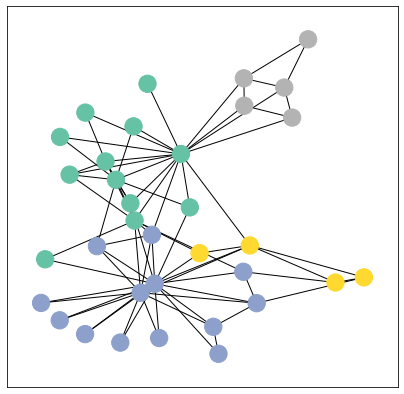

In [40]:
visualize(G, color=data.y)

## Implementing Graph Neural Networks

In [48]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

import matplotlib.pyplot as plt

In [42]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

In [43]:
model = GCN()

In [44]:
model

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)

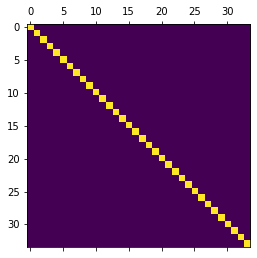

In [49]:
plt.matshow(data.x)

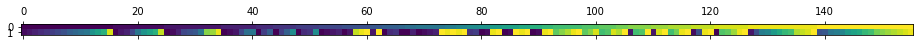

In [50]:
plt.matshow(data.edge_index)

In [51]:
out = model(data.x, data.edge_index)

In [61]:
out, h = out

In [63]:
out

tensor([[-0.5967, -0.3627,  0.2102, -0.6589],
        [-0.6052, -0.3653,  0.2181, -0.6615],
        [-0.6084, -0.3650,  0.2185, -0.6609],
        [-0.5827, -0.3609,  0.2022, -0.6576],
        [-0.6220, -0.3622,  0.2173, -0.6567],
        [-0.6141, -0.3602,  0.2106, -0.6546],
        [-0.6143, -0.3605,  0.2113, -0.6550],
        [-0.5941, -0.3628,  0.2096, -0.6592],
        [-0.6374, -0.3684,  0.2345, -0.6632],
        [-0.6036, -0.3652,  0.2175, -0.6616],
        [-0.6190, -0.3625,  0.2169, -0.6572],
        [-0.5870, -0.3634,  0.2085, -0.6603],
        [-0.5883, -0.3596,  0.2013, -0.6556],
        [-0.6049, -0.3643,  0.2160, -0.6603],
        [-0.6569, -0.3680,  0.2400, -0.6615],
        [-0.6480, -0.3687,  0.2385, -0.6630],
        [-0.6106, -0.3594,  0.2079, -0.6539],
        [-0.6212, -0.3664,  0.2254, -0.6619],
        [-0.6440, -0.3687,  0.2373, -0.6632],
        [-0.6287, -0.3663,  0.2275, -0.6612],
        [-0.6509, -0.3674,  0.2368, -0.6611],
        [-0.6060, -0.3627,  0.2131

## Training on the Karate Club Network

In [56]:
import torch.nn as nn

In [57]:
criterion = nn.CrossEntropyLoss()

In [59]:
h[data.train_mask]

tensor([[-0.0277, -0.0044],
        [ 0.0093, -0.0047],
        [ 0.0273,  0.0230],
        [ 0.0664,  0.0200]], grad_fn=<IndexBackward>)

In [60]:
data.y[data.train_mask]

tensor([0, 3, 1, 2])

In [64]:
# 이해가 안가는거... batch가 아니라 하나의 그래프만 입력으로 하나?

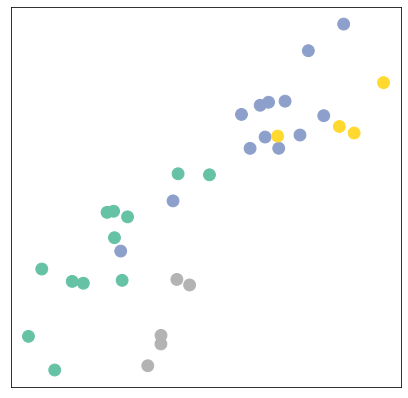

In [70]:
visualize(h, color=data.y)

In [ ]:
loss = criterion()

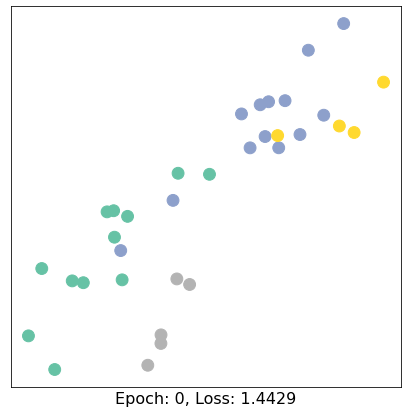

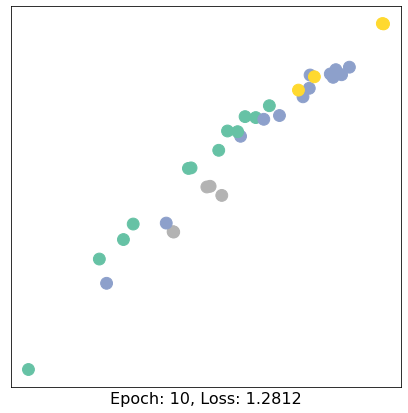

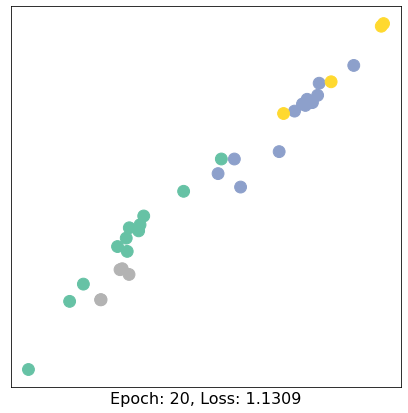

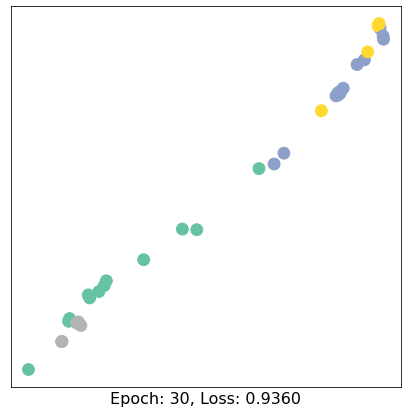

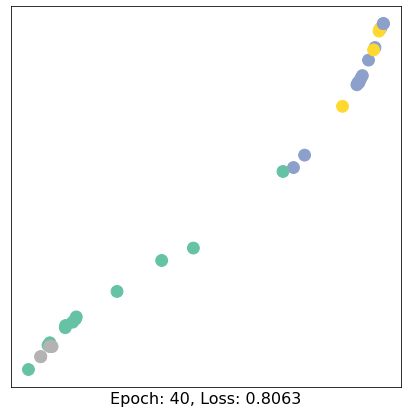

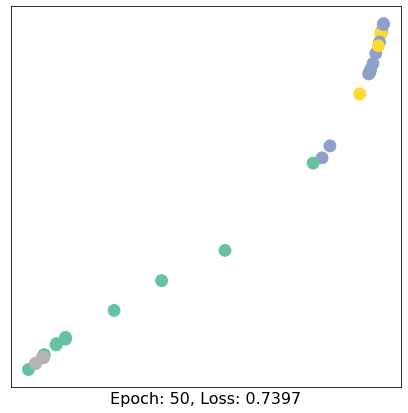

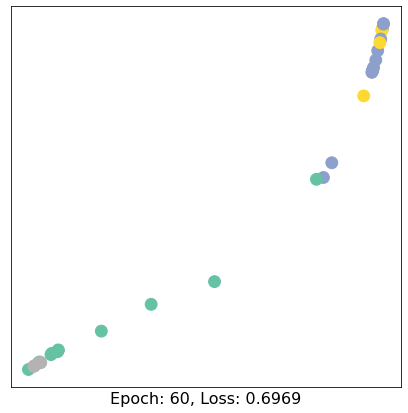

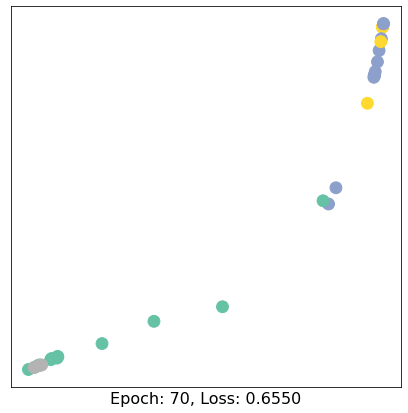

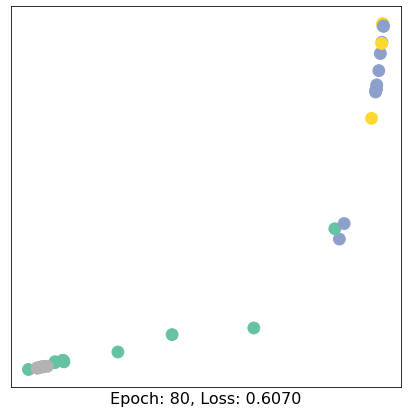

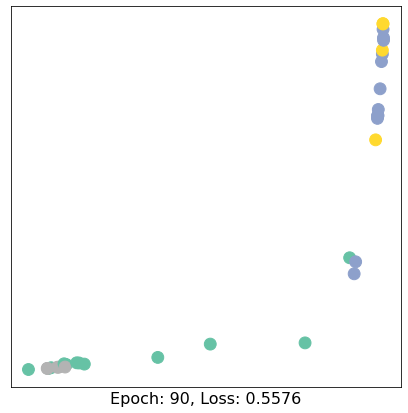

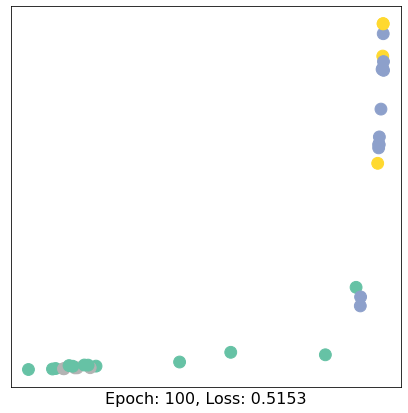

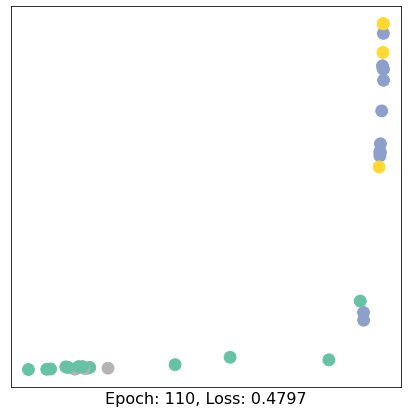

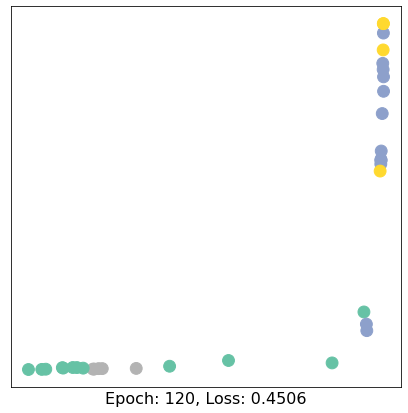

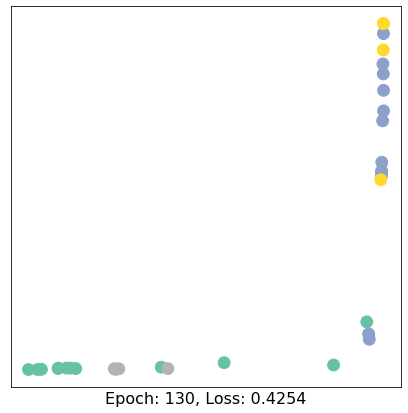

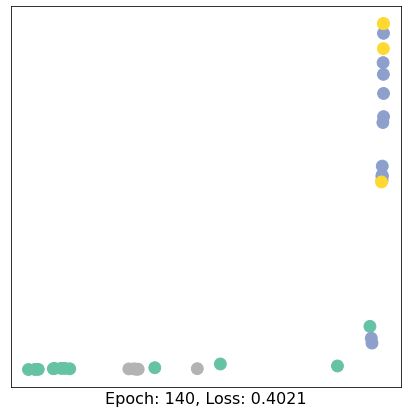

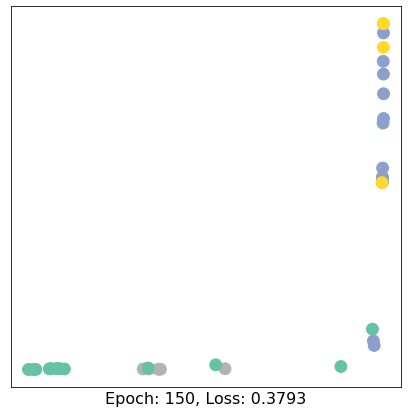

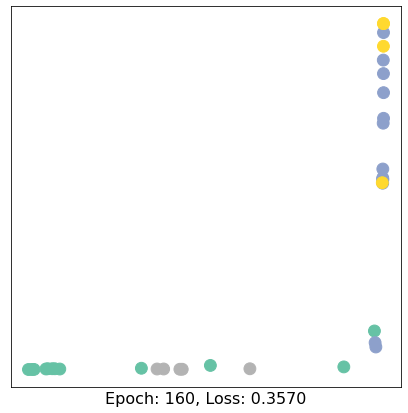

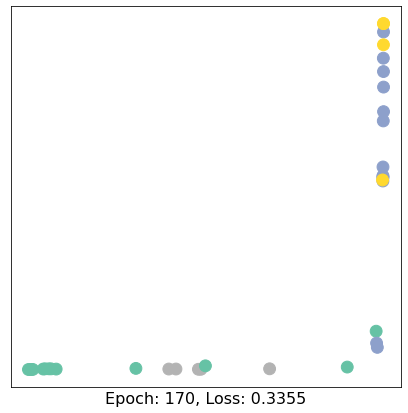

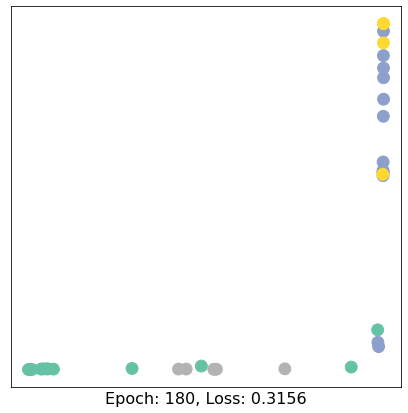

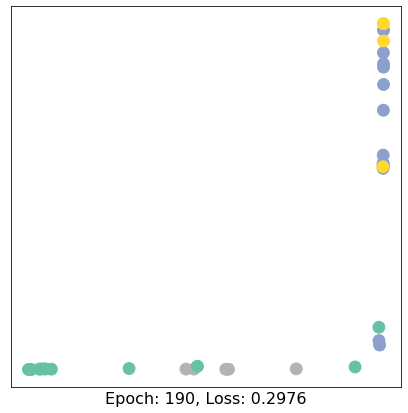

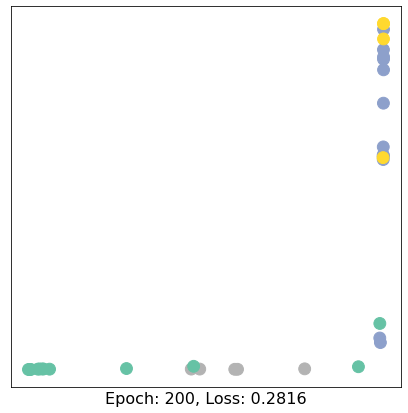

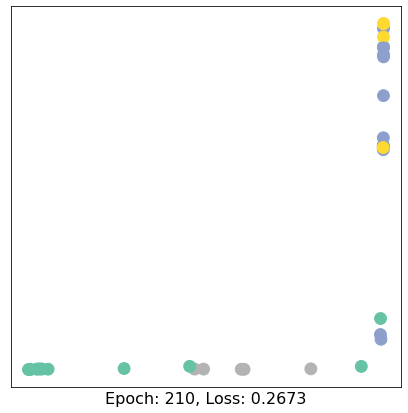

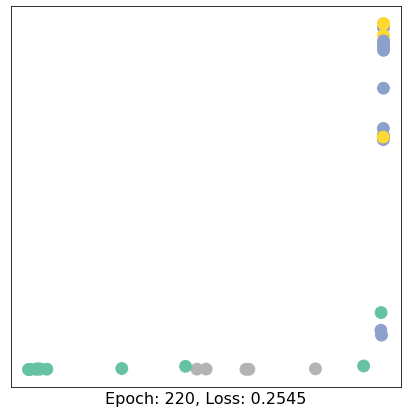

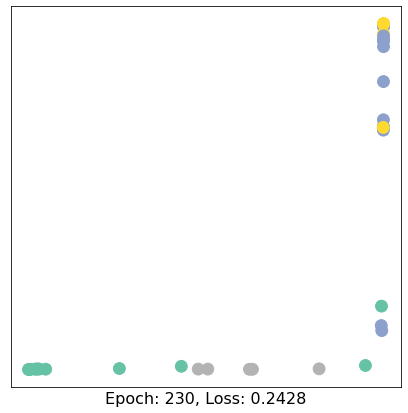

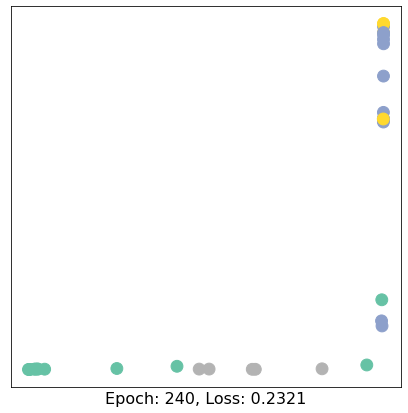

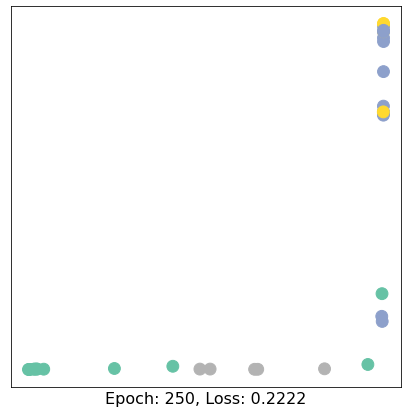

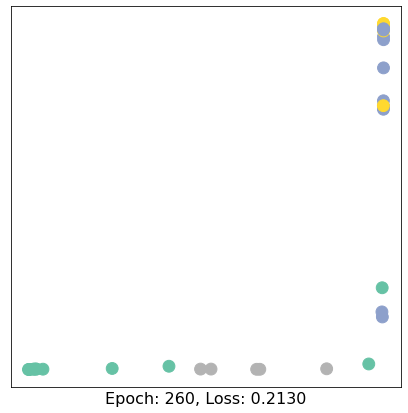

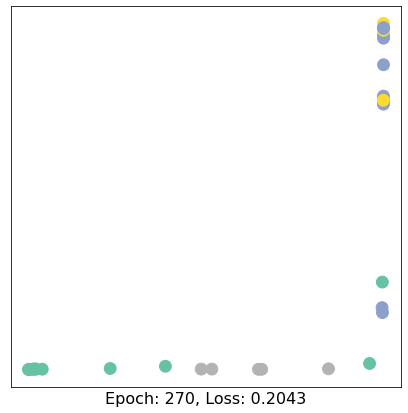

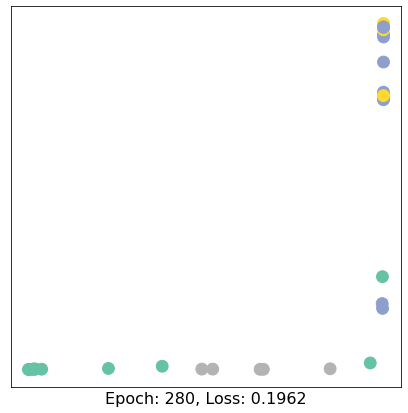

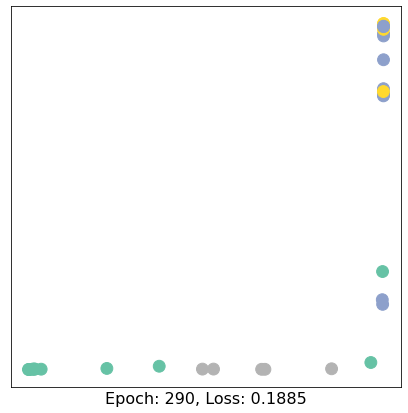

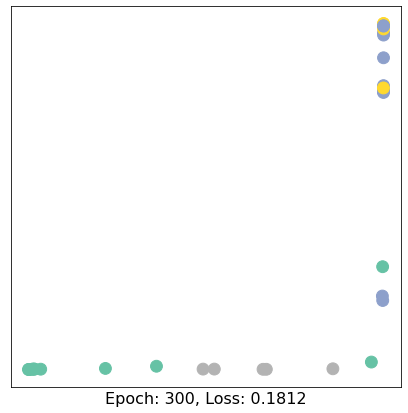

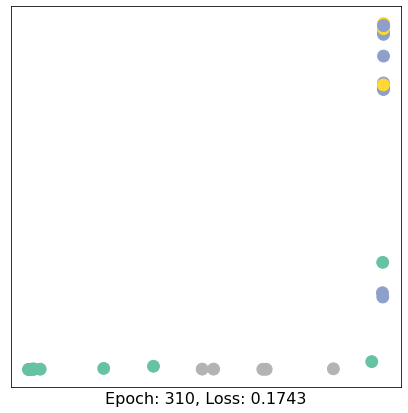

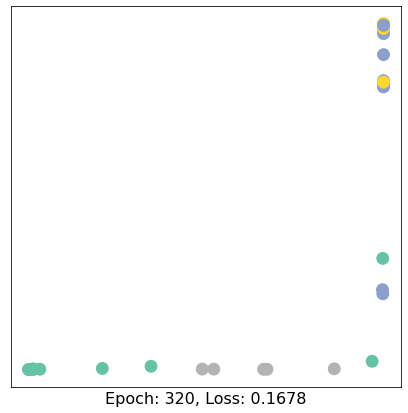

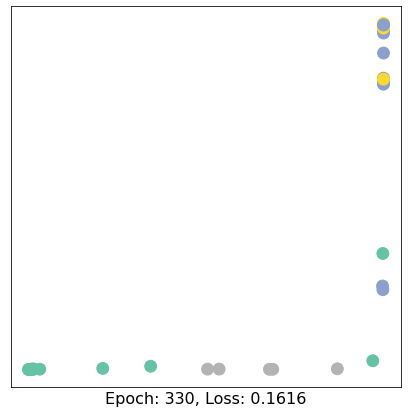

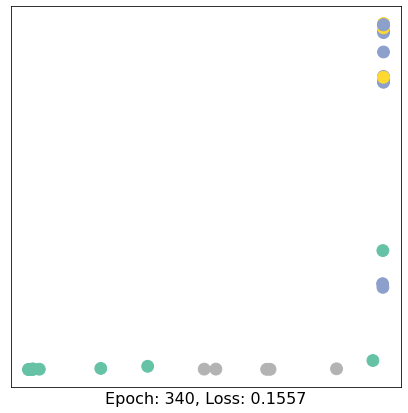

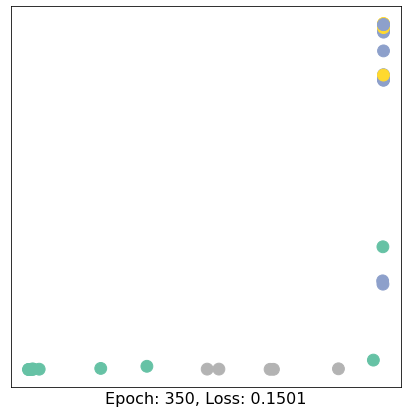

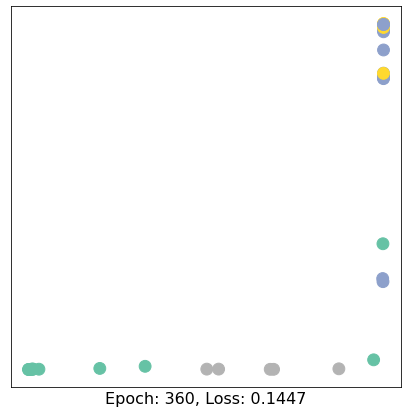

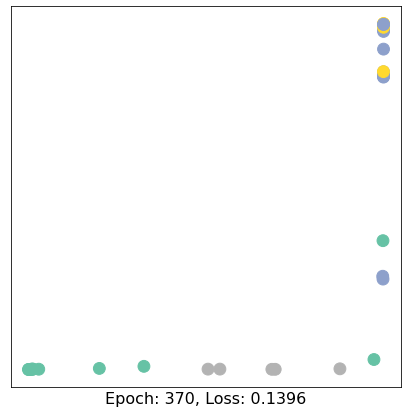

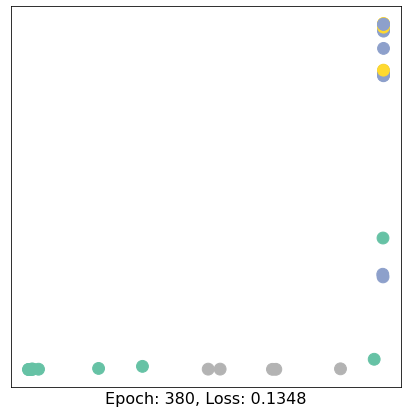

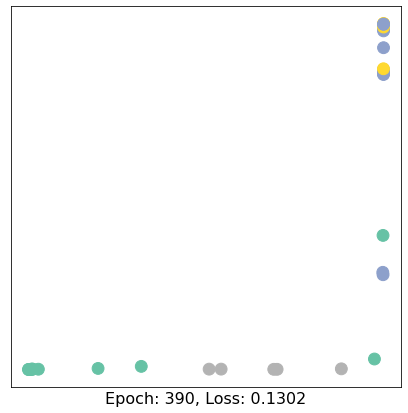

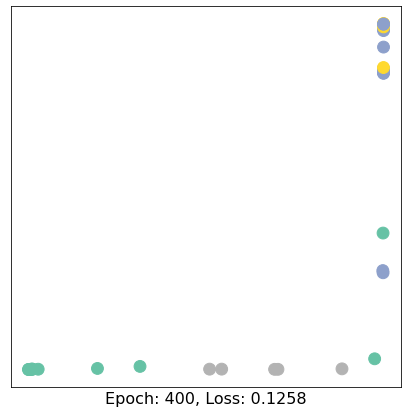

In [71]:
import time

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.


def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h


for epoch in range(401):
    loss, h = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)